# Working with scikit-learn

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Pre-processing

We load the dataset, drop the columns which do not contribute much to the prediction (according to the assignment handout), and we convert the `income` column from text to numerical values. We make sure that all income labels have been mapped to a numerical value so that there is no missing values in this column.

In [2]:
dataset = pd.read_csv('adult_data.csv', index_col=0)

to_drop = ['fnlwgt', 'education', 'capital-gain', 'capital-loss', 'native-country']
clean_dataset = dataset.drop(columns=to_drop)
clean_dataset['income'] = clean_dataset['income'].map({'<=50K.':0, '<=50K':0, '>50K':1, '>50K.':1})
assert clean_dataset.isna().sum()['income'] == 0

We now check for missing values in the remaining columns.

In [3]:
clean_dataset.isna().sum()

age                  0
workClass         2799
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
hours-per-week       0
income               0
dtype: int64

The `workClass` and `occupation` columns both have ~3000 missing values. Let's explore the value distributions of these columns.

In [4]:
clean_dataset['workClass'].value_counts(normalize=True)

Private             0.736399
Self-emp-not-inc    0.083878
Local-gov           0.068110
State-gov           0.043025
Self-emp-inc        0.036813
Federal-gov         0.031101
Without-pay         0.000456
Never-worked        0.000217
Name: workClass, dtype: float64

In [5]:
clean_dataset['occupation'].value_counts(normalize=True)

Prof-specialty       0.134078
Craft-repair         0.132774
Exec-managerial      0.132210
Adm-clerical         0.121891
Sales                0.119566
Other-service        0.106945
Machine-op-inspct    0.065649
Transport-moving     0.051159
Handlers-cleaners    0.045011
Farming-fishing      0.032368
Tech-support         0.031412
Protective-serv      0.021354
Priv-house-serv      0.005257
Armed-Forces         0.000326
Name: occupation, dtype: float64

For the `workClass` column, we can safley fill missing values by the most frequently occuring value `Private`, as it occurs in more than 73% of the dataset.
However, the `occupation` column is more evenly distributed, and unfortunately it is probable that this column have a significant influence over the `income` column we are trying to predict. To follow the instructions, we will fill NA values with `Prof-specialty`, but a smarter cleaning technique should be applied here.

In [6]:
clean_dataset.fillna({'occupation': 'Prof-specialty', 'workClass': 'Private'}, inplace=True)
clean_dataset.isna().sum()

age               0
workClass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
hours-per-week    0
income            0
dtype: int64

Now that we have cleaned the datatset, we convert the categorical values to numerical values through one-hot
encoding. The only columns which are not categorical are `age` and `hours-per-week`.

In [7]:
categorical = ['workClass', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
try:
    clean_dataset = pd.get_dummies(clean_dataset, columns=categorical)
except KeyError:
    print('Dataset has already beeen converted to categorical')
clean_dataset.head()

,age,hours-per-week,income,workClass_Federal-gov,workClass_Local-gov,workClass_Never-worked,workClass_Private,workClass_Self-emp-inc,workClass_Self-emp-not-inc,workClass_State-gov,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,36,74,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,54,39,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
2,26,71,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,71,10,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,33,75,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0


## Splitting the dataset

Now that our dataset has been cleaned and encoded, we can use machine learning algorithms to classify the `income` class based on the features. To do so, we first split the data into training and testing sets, with 30% of the data being used for evaluation.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

In [9]:
input_columns = clean_dataset.drop(columns=['income'])
output_column = clean_dataset['income']
x_train, x_test, y_train, y_test = train_test_split(input_columns, output_column, test_size=0.3, random_state=42)

To display the confusion matrices, we will use the utility function below, adapted from [sklearn's documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [10]:
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    
    title = 'Confusion matrix without normalization'
    title_normalized = 'Normalized confusion matrix'
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = ['< 50k', '> 50k']
        
        
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
    im0 = ax0.imshow(cm, interpolation='nearest', cmap=cmap)
    im1 = ax1.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    ax0.figure.colorbar(im0, ax=ax0)
    ax1.figure.colorbar(im1, ax=ax1)
    
    axes = dict(xticks=[0, 1], yticks=[0, 1], ylim=[-0.5, 1.5], xticklabels=classes, yticklabels=classes, ylabel='True label', xlabel='Predicted label')
    
    ax0.set(**axes, title=title)
    ax1.set(**axes, title=title_normalized)

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    thresh_n = cm_normalized.max() / 2.
    for i, i_n in zip(range(cm.shape[0]), range(cm_normalized.shape[0])):
        for j, j_n in zip(range(cm.shape[1]), range(cm_normalized.shape[1])):
            ax0.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
            ax1.text(j_n, i_n, format(cm_normalized[i_n, j_n], '.2f'),
                    ha="center", va="center",
                    color="white" if cm_normalized[i_n, j_n] > thresh_n else "black")
            

## Classification with K-Nearest Neighbour Classifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy : 74.93%
ROC score : 62.01%


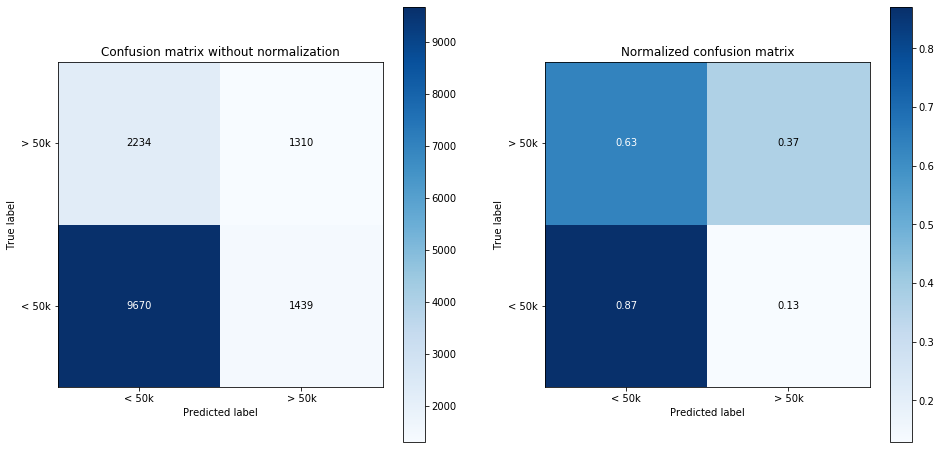

In [12]:
model = KNeighborsClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred):.2%}')
print(f'ROC score : {roc_auc_score(y_test, y_pred):.2%}')
plot_confusion_matrix(y_test, y_pred)

## Classification with Decision Tree Classifier

In [13]:
from sklearn.tree import DecisionTreeClassifier

Accuracy : 74.35%
ROC score : 64.79%


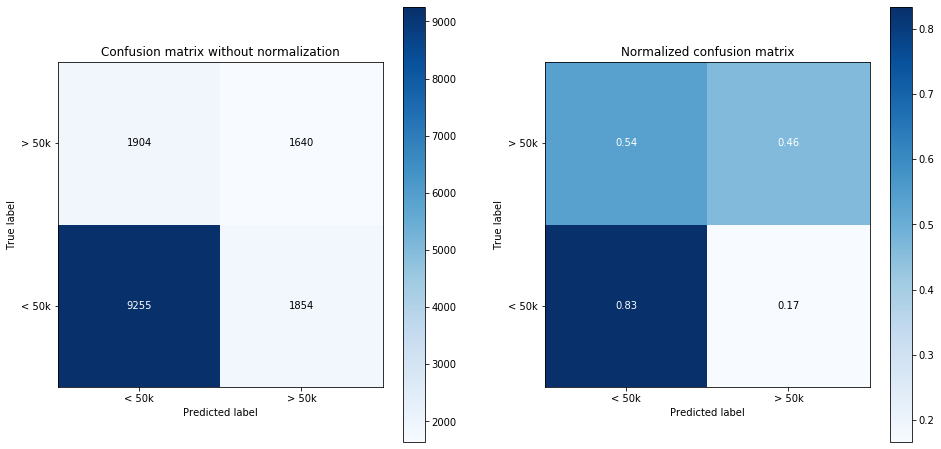

In [14]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred):.2%}')
print(f'ROC score : {roc_auc_score(y_test, y_pred):.2%}')
plot_confusion_matrix(y_test, y_pred)

## Baseline classification

In [15]:
from sklearn.dummy import DummyClassifier

Accuracy : 75.81%
ROC score : 50.00%


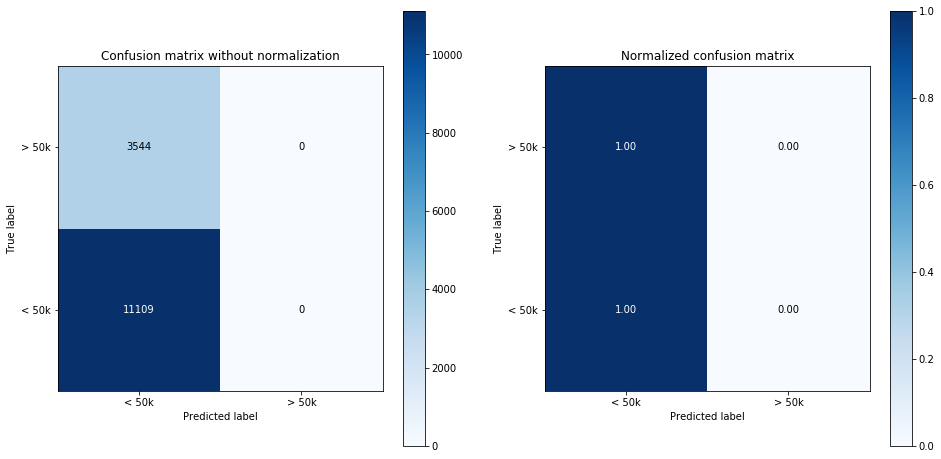

In [16]:
model = DummyClassifier(strategy='most_frequent')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred):.2%}')
print(f'ROC score : {roc_auc_score(y_test, y_pred):.2%}')
plot_confusion_matrix(y_test, y_pred)

## Results

With the KNN and Decision Tree classifiers we get approximately 75% accuracy, which could seem like a great score but actually relies on a biased metric which doesn't tell us anything useful about the classifiers performance in this case. This is because the dataset suffers from a class imbalance of 76% towards the `< 50k` class. We can see that a dummy classifier, classifying every test instance as the majority class would outperform the accuracy of both machine learning classifiers. In this case, the accuracy metric is not really useful. 

However, we can see that the ROC AUC score gains a 12% to 15% improvement over the baseline classifier, which means that the machine learning models with default parameters are not completely useless. To make them useful, we would need to tell them about the class imbalance, and tune their hyperparameters, but this is outside of the scope of this assignment.

In [17]:
clean_dataset['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64